# Clustering

While other methods of machine learning are *supervised* -- meaning they begin with a set of labeled data -- clustering is an example of unsupervised learning, meaning that it begins with a set of unlabeled data.  Data will almost always form clusters.  A data set showing where millionaires live probably has clusters in places like Beverly Hills and Manhatten.  There is generally no "correct" clustering.  Also, clusters don't label themselves.  You'll need to do that by looking at the underlying data for each one.

For us, each `input` will be a vector in d-dimensional space, which we will represent as a list of numbers.  Our goal will be to identify clusters of similar inputs and to find a representative value for each cluster.  For example, each input could be a numeric vector that somehow represents the title of a blog post, in which case the goal might be to find clusters of similar posts, perhaps in order to understand what our users are blogging about.  One of the simplest clustering methods is *k-means*, in which the number of clusters `k` is chosen in advance, after which the goal is to partition the inputs into sets $ S_i, ..., S_k $ in a way that minimizes the total sum of squared distances from each point to the mean of its assigned cluster.

There are lots of ways to assign *n* points to *k* clusters, which means that finding an optimal clustering is a very hard problem.  We'll settle for an iterative algorithm that usually finds a good clustering:

1. Start with a set of *k-means*, which are points in d-dimensional space.
2. ASsign each point to the mean to which it is closest.
3. If no point's assignment has changed, stop and keep the clusters.
4. If some point's assignment has changed, recompute the means and return to step 2.

Using the `vector_mean` function, it's pretty simple to create a class that does this:

In [1]:
from code_python3.linear_algebra import squared_distance, vector_mean, distance
import math, random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

class KMeans:
    """performs k-means clustering"""

    def __init__(self, k):
        self.k = k          # number of clusters
        self.means = None   # means of clusters

    def classify(self, input):
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs):

        self.means = random.sample(inputs, self.k)
        assignments = None

        while True:
            # Find new assignments
            new_assignments = list(map(self.classify, inputs))

            # If no assignments have changed, we're done.
            if assignments == new_assignments:
                return

            # Otherwise keep the new assignments,
            assignments = new_assignments

            for i in range(self.k):
                i_points = [p for p, a in zip(inputs, assignments) if a == i]
                # avoid divide-by-zero if i_points is empty
                if i_points:
                    self.means[i] = vector_mean(i_points)

Let's take a look at how this works.  Let's take the meetup example:

In [3]:
inputs = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

random.seed(0) # so you get the same results as me
clusterer = KMeans(3)
clusterer.train(inputs)
print("3-means:")
print(clusterer.means)

3-means:
[[-25.857142857142854, -4.714285714285714], [20.0, 26.0], [16.666666666666664, 13.666666666666666]]


We find three clusters, and it allows you to look for meetup venues centered around those locations.  If we take a look at two meetups:

In [4]:
random.seed(0)
clusterer = KMeans(2)
clusterer.train(inputs)
print("2-means:")
print(clusterer.means)
print()

2-means:
[[-25.857142857142854, -4.714285714285714], [18.333333333333332, 19.833333333333332]]



In the previous example, the choice of *k* was driven by factors outside of our control.  In general, this won't be the case.  There is a wide variety of ways to choose a *k*.  One that's reasonably easy to understand involves plotting the sum of squared errors between each point and the mean of its cluster as a function of *k* and looking at where the graph "bends":

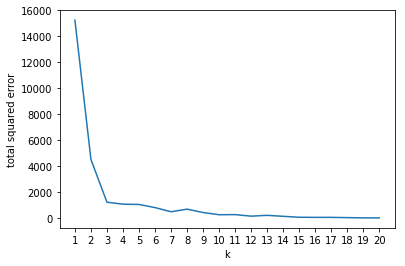

In [5]:
def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = list(map(clusterer.classify, inputs))

    return sum(squared_distance(input,means[cluster])
               for input, cluster in zip(inputs, assignments))

def plot_squared_clustering_errors():

    ks = range(1, len(inputs) + 1)
    errors = [squared_clustering_errors(inputs, k) for k in ks]

    plt.plot(ks, errors)
    plt.xticks(ks)
    plt.xlabel("k")
    plt.ylabel("total squared error")
    plt.show()
    
plot_squared_clustering_errors()

This method agrees with our original eyeballing that 3 is the "right" number of clusters.  Another example of clustering can determine the optimal number of colors to display when generating images.  They can be represented as a two-dimensional array of pixels, where each pixel is itself a three-dimensional vector indicating its color.

Creating a five-color version of the image then entails:

1. Choosing five colors
2. ASsigning one of those colors to each pixel

It turns out this is a great taks for k-means clustering, which can partition the pixels into five clusters in red-green-blue space.  If we then recolor the pixels in each cluster to the mean color, we're done.  To start with, we'll need a way to load an image into Python.  It turns out we can do this with `matplotlib`:

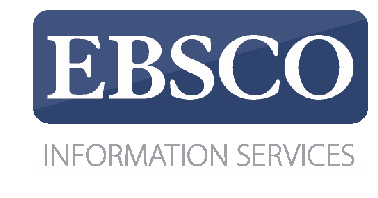

In [16]:
def recolor_image(input_file, k=5):
    '''
    input_file: takes a png file.  the jpeg file that was used was large so it could have been too large for the
    function to process.
    '''
    img = mpimg.imread(input_file)
    pixels = [pixel for row in img for pixel in row]
    clusterer = KMeans(k)
    clusterer.train(pixels) # this might take a while

    def recolor(pixel):
        cluster = clusterer.classify(pixel) # index of the closest cluster
        return clusterer.means[cluster]     # mean of the closest cluster

    new_img = [[recolor(pixel) for pixel in row]
               for row in img]

    plt.imshow(new_img)
    plt.axis('off')
    plt.show()
    
recolor_image(input_file="/home/jovyan/work/EBSCO_Information_Services_logo.png", k=5)

An alternative to clustering is to "grow" clusters from the bottom up.  We ca do this in the following way:

1. MAke each input its own cluster of one.
2. As long as there are multiple clusters remaining, find the two closest clusters and merge them.

At the wend, we'll have one giant cluster containing all the inputs.  If we keep track of the merge order, we can recreate any number of clusters by unmerging.  For example, if we want three clusters, we can just undo the last two merges.  We'll use a really simple representation of clusters.  Our values will live in *leaf* clusters, which we will represent as 1-tuples:

In [17]:
leaf1 = ([10, 20],) # to make a 1-tuple you need the trailing comma
leaf2 = ([30, -15],) # otherwise Python treats the parentheses as parentheses

We'll use these to grow merged clusters, which we will represent as 2-tuples (merge order, children):

In [19]:
merged = (1, [leaf1, leaf2])

We'll talk about merge order in a bit, but first let's create a few helper functions:

In [20]:
def is_leaf(cluster):
    """a cluster is a leaf if it has length 1"""
    return len(cluster) == 1

def get_children(cluster):
    """returns the two children of this cluster if it's a merged cluster;
    raises an exception if this is a leaf cluster"""
    if is_leaf(cluster):
        raise TypeError("a leaf cluster has no children")
    else:
        return cluster[1]

def get_values(cluster):
    """returns the value in this cluster (if it's a leaf cluster)
    or all the values in the leaf clusters below it (if it's not)"""
    if is_leaf(cluster):
        return cluster # is already a 1-tuple containing value
    else:
        return [value
                for child in get_children(cluster)
                for value in get_values(child)]

In order to merge the closest clusters, we need some notion of the distance between clusters.  We'll use the minimum distance between elements of the two clusters, which merges the two clusters that are closest to touching (but will sometimes produce large chain-=like clusters that aren't very tight).  If we wanted tight spherical clusters, we might use the maximum distance instead, as it merges the two clusters that fit in the smallest ball.  Both are common choices, as is the average distance:

In [21]:
def cluster_distance(cluster1, cluster2, distance_agg=min):
    """finds the aggregate distance between elements of cluster1
    and elements of cluster2"""
    return distance_agg([distance(input1, input2)
                        for input1 in get_values(cluster1)
                        for input2 in get_values(cluster2)])

We'll use the merge order slot to track the order in which we did the merging.  Smaller numbers will represent later merges.  This means when we want to unmerge clusters, we do so from lowest merge order to highest.  Since leaf clusters were never merged, which means we never want to unmerge them, we'll assign them infinity:

In [22]:
def get_merge_order(cluster):
    if is_leaf(cluster):
        return float('inf')
    else:
        return cluster[0] # merge_order is first element of 2-tuple

Now we're ready to create the clustering algorithm:

In [24]:
def bottom_up_cluster(inputs, distance_agg=min):
    # start with every input a leaf cluster / 1-tuple
    clusters = [(input,) for input in inputs]

    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min([(cluster1, cluster2)
                     for i, cluster1 in enumerate(clusters)
                     for cluster2 in clusters[:i]],
                     key=lambda p: cluster_distance(p[0], p[1], distance_agg))

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = (len(clusters), [c1, c2])

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

Its use is very simple:

In [25]:
base_cluster = bottom_up_cluster(inputs)
print(base_cluster)

(0, [(1, [(3, [(14, [(18, [([19, 28],), ([21, 27],)]), ([20, 23],)]), ([26, 13],)]), (16, [([11, 15],), ([13, 13],)])]), (2, [(4, [(5, [(9, [(11, [([-49, 0],), ([-46, 5],)]), ([-41, 8],)]), ([-49, 15],)]), ([-34, -1],)]), (6, [(7, [(8, [(10, [([-22, -16],), ([-19, -11],)]), ([-25, -9],)]), (13, [(15, [(17, [([-11, -6],), ([-12, -8],)]), ([-14, -5],)]), ([-18, -3],)])]), (12, [([-13, -19],), ([-9, -16],)])])])])


For every merged cluster, if we say "cluster 0" for the cluster with merge order 0, you can interpret this as:

- Cluster 0 is the merger of cluster 1 and cluster 2.
- Cluster 1 is the merger of cluster 3 and cluster 16.
- Cluster 16 is the merger of the leaf `[11, 15]` and the leaf `[13, 13]`.
- And so on...

Since we had 20 inputs, it took 19 merges to get to this one cluster.  The first merge created cluster 18 by combining the leaves `[19, 28]` and `[21, 27]`.  Abd the last merge created cluster 0.  Generally, we don't want to be squinting at nasty text representations like this:

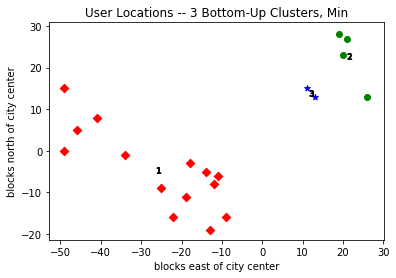

In [27]:
def generate_clusters(base_cluster, num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]
        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

three_clusters = [get_values(cluster) for cluster in generate_clusters(base_cluster, 3)]
for i, cluster, marker, color in zip([1, 2, 3], three_clusters, ['D', 'o', '*'], ['r', 'g', 'b']):
    xs, ys = zip(*cluster) # magic unzipping trick
    plt.scatter(xs, ys, color=color, marker=marker)
    
    # put a number at the mean of the cluster
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title("User Locations -- 3 Bottom-Up Clusters, Min")
plt.xlabel("blocks east of city center")
plt.ylabel("blocks north of city center")
plt.show()

This gives very different results than k-means did.  As we mentioned above this is because using `min` in `cluster_distances` tends to give chain-like clusters.  If we instead use `max` (which gives tight clusters) it looks the same as the 3-means result.